# Understanding quality and accuracy (auc-roc) -- step 5
Modifying James Requa's Kaggle notebook: https://www.kaggle.com/jamesrequa/keras-k-fold-inception-v3-1st-place-lb-0-99770/notebook

In [1]:
nb_version = "UE" # notebook version: Understanding_E

In [2]:
# TRY ggplot2
# TRY callbacks = [plot_losses]
#  in model.fit
#  see https://keras.rstudio.com/articles/training_visualization.html
#  see https://medium.com/@kapilvarshney/how-to-plot-the-model-training-in-keras-using-custom-callback-function-and-using-tensorboard-41e4ce3cb401
import os
import glob
import pickle
import numpy as np
import pandas as pd
import cv2
import h5py
import tensorflow as tf
import keras
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib
from matplotlib import pylab, mlab
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize, getfigs
#from pylab import *
#from numpy import *
%matplotlib inline
import matplotlib.image as mpimg
from sklearn.utils import shuffle

Using TensorFlow backend.


# Data
We need to prepare the data to be labelled correctly and input properly into our model.

In [3]:
path = '../../data/1-pre-processed/C'
colon_normal   = glob.glob(path+'/Normal/*.jpg')
colon_abnormal = glob.glob(path+'/Abnormal/*.jpg')
dfn = pd.DataFrame()
dfa = pd.DataFrame()
dfn['filepath'] = colon_normal
dfa['filepath'] = colon_abnormal
dfn['abnormality'] = 0
dfa['abnormality'] = 1
splitPoint = int(0.8*len(colon_abnormal))
print(f'splitPoint = {splitPoint}')
n_train = dfn[:splitPoint]
n_test  = dfn[splitPoint:]
a_train = dfa[:splitPoint]
a_test  = dfa[splitPoint:]
df_train = pd.concat([n_train,a_train])
df_test  = pd.concat([n_test,a_test])
df_train = shuffle(df_train).reset_index(drop=True)
df_test  = shuffle(df_test).reset_index(drop=True)

train_set    = df_train
train_labels = np.array(train_set['abnormality'].iloc[: ])
train_files  = df_train['filepath'].tolist()

test_set    = df_test
test_labels = np.array(test_set['abnormality'].iloc[: ])
test_files  = df_test['filepath'].tolist()

print(train_set.head())
print(test_set.head())

print(f'\nTrain distribution:\n{train_set["abnormality"].value_counts()}')
print(f'\nTest distribution:\n{test_set["abnormality"].value_counts()}')

splitPoint = 80
                                            filepath  abnormality
0  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1
1  ../../data/1-pre-processed/C/Normal/2805206 01...            0
2  ../../data/1-pre-processed/C/Normal/2537954 30...            0
3  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1
4  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1
                                            filepath  abnormality
0  ../../data/1-pre-processed/C/Normal/2537954 30...            0
1  ../../data/1-pre-processed/C/Normal/1376916 20...            0
2  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1
3  ../../data/1-pre-processed/C/Normal/2805206 01...            0
4  ../../data/1-pre-processed/C/Abnormal/9092882 ...            1

Train distribution:
1    80
0    80
Name: abnormality, dtype: int64

Test distribution:
1    20
0    20
Name: abnormality, dtype: int64


In [4]:
n_train.iloc[0][0]

'../../data/1-pre-processed/C/Normal/2537954 30 Dec 18_1 00942.jpg'

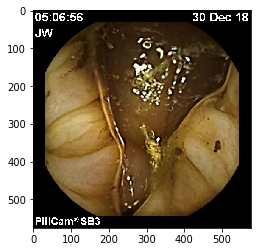

type(img) = <class 'numpy.ndarray'>
img.shape = (576, 576, 3)
          = (img_height, img_width, img_channels)


In [5]:
img = mpimg.imread(n_train.iloc[0][0])
imgplot = plt.imshow(img)
plt.show()
print(f'type(img) = {type(img)}')
print(f'img.shape = {img.shape}')
print( "          = (img_height, img_width, img_channels)")

img_height = img.shape[0]
img_width = img.shape[1]
img_channels = img.shape[2]
img_shape = (img_height, img_width, img_channels)
img_size  = (img_height, img_width)

# Model
We need to define, compile, train, and test our model.  (We'll put the `compile` part in the `train_model` function.)

Also will want to use the trained and tested model to make more predictions.

In [6]:
def mobilenet_v2_a(img_dim=img_shape):
    # base network to be built around:
    base_model = MobileNetV2(input_shape=None,
                             #input_shape=img_dim,
                             alpha=1.0,
                             depth_multiplier=1,
                             include_top=False,
                             weights='imagenet',
                             input_tensor=None,
                             pooling=None
                             #classes=1000
                            )
    for layer in base_model.layers:
        layer.trainable = False
    #for layer in base_model.layers[:153]:
    #    layer.trainable = False
    #for layer in base_model.layers[153:]:
    #    layer.trainable = True

    xi = Input(shape=img_dim)              # input tensor
    x  = BatchNormalization()(xi)          # next layer
    x  = base_model(x)                     # Each x on the right refers to
    x  = Dropout(0.5)(x)                   #  the previous x on the left.
    x  = Flatten()(x)                      # 
    xo = Dense(1, activation='sigmoid')(x) # output tensor
    model = Model(inputs=xi, outputs=xo, name='mobilenet_v2_a')
    return model

model = mobilenet_v2_a()

print(f'model name: {model.name}')
model.summary()
# model.name    # (a string, the name of the model)
# model.summary # (a printout summarizing the model)
# model.layers  # (a set of layer objects?)
# model.inputs  # (a [set of] tensor objects)
# model.outputs # (a [set of] tensor objects)

/Users/zero/Tools/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:306: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


model name: mobilenet_v2_a
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 576, 576, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 576, 576, 3)       12        
_________________________________________________________________
mobilenetv2_1.00_224 (Model) multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 1280)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 414720)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 414721    
Total params: 2,672,717
Trainable params: 414,727
Non-trainable params: 2,257,990
_________________________________

In [7]:
def train_model(input_model, batch_size, epochs, img_size,
                x, y, test, n_fold, kf, nb_v, j):

    roc_auc      = metrics.roc_auc_score
    preds_train  = np.zeros(len(x), dtype = np.float)
    preds_test   = np.zeros(len(test), dtype = np.float)
    train_scores = []; valid_scores = []

    model = input_model

    os.makedirs(f'./chkpts/{model.name}/{nb_v}', exist_ok=True)
    os.makedirs(f'./tb_logs/{model.name}/{nb_v}',exist_ok=True)

    print(f'\n')
    print(f'Training: Run {j:02d}')
    print(f'----------------\n\n')
    os.makedirs(f'./chkpts/{model.name}/{nb_v}/Run_{j:02d}', exist_ok=True)  # for /weights_fold_{str(i)}.hdf5
    os.makedirs(f'./tb_logs/{model.name}/{nb_v}/Run_{j:02d}',exist_ok=True)  # for /tb_fold_{str(i)}/etcetera

    # "Fold" counter
    i = 0
    # histories of each fold
    histories_ = []

    for train_index, valid_index in kf.split(x):
        x_train = x.iloc[train_index]; x_valid = x.iloc[valid_index]
        y_train = y[train_index]; y_valid = y[valid_index]
        
        i += 1
        print(f'Now beginning training for fold {i}\n')

        def augment(src, choice):
            if choice == 0:
                # Rotate 90
                src = np.rot90(src, 1)
            if choice == 1:
                # flip vertically
                src = np.flipud(src)
            if choice == 2:
                # Rotate 180
                src = np.rot90(src, 2)
            if choice == 3:
                # flip horizontally
                src = np.fliplr(src)
            if choice == 4:
                # Rotate 90 counter-clockwise
                src = np.rot90(src, 3)
            if choice == 5:
                # Rotate 180 and flip horizontally
                src = np.rot90(src, 2)
                src = np.fliplr(src)
            return src

        def train_generator():
            while True:
                for start in range(0, len(x_train), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(x_train))
                    train_batch = x_train[start:end]
                    for filepath, tag in train_batch.values:
                        img = cv2.imread(filepath)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, img_size)
                        img = augment(img, np.random.randint(6))
                        x_batch.append(img)
                        y_batch.append(tag)
                    x_batch = np.array(x_batch, np.float32) / 255.
                    y_batch = np.array(y_batch, np.uint8)
                    yield x_batch, y_batch

        def valid_generator():
            while True:
                for start in range(0, len(x_valid), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(x_valid))
                    valid_batch = x_valid[start:end]
                    for filepath, tag in valid_batch.values:
                        img = cv2.imread(filepath)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, img_size)
                        #img = augment(img, np.random.randint(6))
                        x_batch.append(img)
                        y_batch.append(tag)
                    x_batch = np.array(x_batch, np.float32) / 255.
                    y_batch = np.array(y_batch, np.uint8)
                    yield x_batch, y_batch

        def test_generator():
            while True:
                for start in range(0, len(test), batch_size):
                    x_batch = []
                    end = min(start + batch_size, len(test))
                    test_batch = test[start:end]
                    for filepath in test_batch:
                        img = cv2.imread(filepath)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, img_size)
                        x_batch.append(img)
                    x_batch = np.array(x_batch, np.float32) / 255.
                    yield x_batch

        train_steps = len(x_train) / batch_size
        valid_steps = len(x_valid) / batch_size
        test_steps = len(test) / batch_size

        os.makedirs(f'./tb_logs/{model.name}/{nb_v}/Run_{j:02d}/tb_fold_{str(i)}',exist_ok=True)
        # for /tb_fold_{str(i)}/logfiles
        # and /weights_fold_{str(i)}.hdf5

        callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=1,
                                       verbose=1, min_lr=1e-7),
                     ModelCheckpoint(filepath =
                                     f'./chkpts/{model.name}/{nb_v}/Run_{j:02d}/weights_fold_{str(i)}.hdf5',
                                     verbose=1, save_best_only=True, save_weights_only=True, mode='auto'),
                     TensorBoard(log_dir = f'./tb_logs/{model.name}/{nb_v}/Run_{j:02d}/tb_fold_{str(i)}/' )
                    ]

        model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy',
                      metrics = ['accuracy'])        

        history = model.fit_generator(train_generator(), train_steps, epochs=epochs, verbose=1,
                                      callbacks=callbacks, validation_data=valid_generator(),
                                      validation_steps=valid_steps)
        histories_.append(history)

        model.load_weights(filepath = f'./chkpts/{model.name}/{nb_v}/Run_{j:02d}/weights_fold_{str(i)}.hdf5' )

        print('Running validation predictions on fold {}'.format(i))
        preds_valid = model.predict_generator(generator=valid_generator(),
                                              steps=valid_steps, verbose=1)[:, 0]

        print('Running train predictions on fold {}'.format(i))
        preds_train = model.predict_generator(generator=train_generator(),
                                              steps=train_steps, verbose=1)[:, 0]

        valid_score = roc_auc(y_valid, preds_valid)
        train_score = roc_auc(y_train, preds_train)
        print('Val Score:{} for fold {}'.format(valid_score, i))
        print('Train Score: {} for fold {}'.format(train_score, i))

        valid_scores.append(valid_score)
        train_scores.append(train_score)
        print('Avg Train Score:{0:0.5f}, Val Score:{1:0.5f} after {2:0.5f} folds'.format
              (np.mean(train_scores), np.mean(valid_scores), i))

        print('Running test predictions with fold {}'.format(i))

        preds_test_fold = model.predict_generator(generator=test_generator(),
                                                  steps=test_steps, verbose=1)[:, -1]

        preds_test += preds_test_fold

        print('\n\n')

    print('Finished training!')

    # Save
    model.save(f'./chkpts/{model.name}/{nb_v}/Run_{j:02d}/ModelWhole_trained_{model.name}_{nb_v}_Run_{j:02d}.hdf5')
    #model = load_model('my_model.hdf5')
    model_json_string = model.to_json()
    with open(f'./chkpts/{model.name}/{nb_v}/Run_{j:02d}/ModelArch_{model.name}_.json', "w") as json_file:
        json_file.write(model_json_string)
    #model = model_from_json(json_string)
    model.save_weights(f'./chkpts/{model.name}/{nb_v}/Run_{j:02d}/ModelWeights_trained_{model.name}_{nb_v}_Run_{j:02d}.hdf5')
    #model.load_weights('my_model_weights.h5')
    # compare with last fold weights (should be same)

    preds_test /= n_fold

    return histories_, preds_test

In [8]:
%%time
batch_size = 4
epochs = 50
n_fold = 4
histories = []

# (Find) Run number
run = 1
while os.path.isdir(f'./chkpts/{model.name}/{nb_version}/Run_{run:02d}'):
    run += 1

os.makedirs(f'./outputs/{model.name}/{nb_version}',exist_ok=True)
file = open(f'./outputs/{model.name}/{nb_version}/train_params_Run_{run:02d}.txt',"w")
file.write(f'batch_size = {batch_size}\n'+
           f'epochs = {epochs}\n'+
           f'n_fold = {n_fold}\n'
          )
file.close()


kf = KFold(n_splits=n_fold, shuffle=True)

histories, test_pred = train_model(model, batch_size, epochs, img_size,
                                   train_set, train_labels, test_files, n_fold, kf, nb_version, run)

test_set['abnormality_pred'] = test_pred
test_set.to_csv(f'./outputs/{model.name}/{nb_version}/output_Run_{run:02d}.csv', index=None)

os.makedirs(f'./for_plots/{model.name}/{nb_version}',exist_ok=True)
f = open(f'for_plots/{model.name}/{nb_version}/histories_Run_{run:02d}.pckl', 'wb')
pickle.dump(f'for_plots/{model.name}/{nb_version}/hist.histories', f)
f.close()



Training: Run 06
----------------


Now beginning training for fold 1

Epoch 1/50
30/30 [==============================] - 144s 5s/step - loss: 1.0122 - acc: 0.7250 - val_loss: 1.1305 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 1.13045, saving model to ./chkpts/mobilenet_v2_a/UD/Run_06/weights_fold_1.hdf5
Epoch 2/50
30/30 [==============================] - 137s 5s/step - loss: 0.1195 - acc: 0.9500 - val_loss: 0.2646 - val_acc: 0.8750

Epoch 00002: val_loss improved from 1.13045 to 0.26457, saving model to ./chkpts/mobilenet_v2_a/UD/Run_06/weights_fold_1.hdf5
Epoch 3/50
30/30 [==============================] - 138s 5s/step - loss: 0.0301 - acc: 0.9917 - val_loss: 0.5359 - val_acc: 0.8750

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00003: val_loss did not improve from 0.26457
Epoch 4/50
30/30 [==============================] - 138s 5s/step - loss: 0.1050 - acc: 0.9667 - val_loss: 0.3047 - val_acc: 0.8750

Epoch 00004: Reduce

In [12]:
histories[0]

history keys = dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])
len(histories) = 4


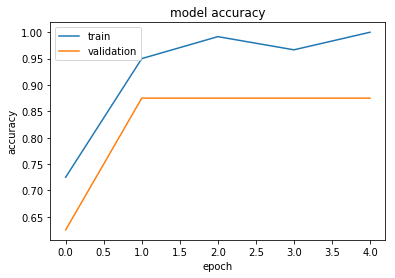

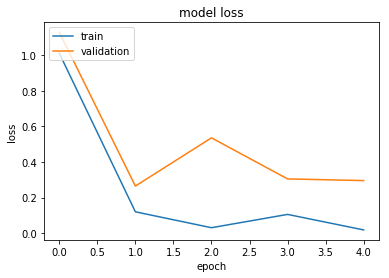

In [17]:
print(f'history keys = {histories[0].history.keys()}')
print(f'len(histories) = {len(histories)}')
# summarize history for accuracy
plt.plot(histories[0].history['acc'])
plt.plot(histories[0].history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histories[0].history['loss'])
plt.plot(histories[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
test_set.head()

,filepath,abnormality,abnormality_pred
0,../../data/1-pre-processed/C/Normal/2537954 30...,0,0.000195
1,../../data/1-pre-processed/C/Abnormal/9092882 ...,1,0.848856
2,../../data/1-pre-processed/C/Normal/2805206 01...,0,0.144619
3,../../data/1-pre-processed/C/Normal/2537954 30...,0,0.000002
4,../../data/1-pre-processed/C/Normal/2537954 30...,0,0.000360


In [27]:
test_set.loc[:, 'abnormality':'abnormality_pred'].head()

,abnormality,abnormality_pred
0,0,0.000195
1,1,0.848856
2,0,0.144619
3,0,0.000002
4,0,0.000360


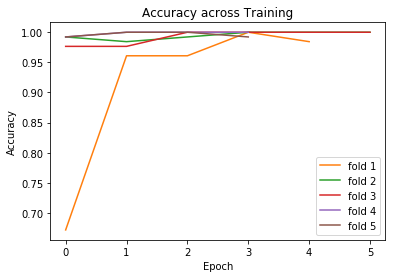

In [9]:
run = 1
data_files = glob.glob(f'./tb_downloads/{model.name}/{nb_version}/Run_{run:02d}/*acc.csv')
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

i = 0
for file in data_files:
    i += 1
    data = pd.read_csv(file) # dataframe
    ax.plot(data['Step'], data['Value'], color=f'C{i}', label=f'fold {i}')

ax.set_title("Accuracy across Training")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
leg = ax.legend()
plt.show()

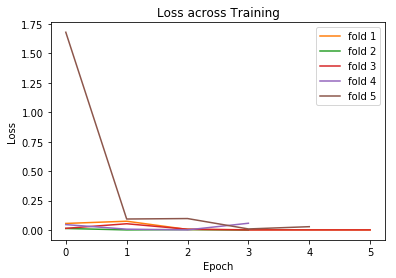

In [10]:
run = 1
data_files = glob.glob(f'./tb_downloads/{model.name}/{nb_version}/Run_{run:02d}/*loss.csv')
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

i = 0
for file in data_files:
    i += 1
    data = pd.read_csv(file) # dataframe
    ax.plot(data['Step'], data['Value'], color=f'C{i}', label=f'fold {i}')

ax.set_title("Loss across Training")
plt.xlabel('Epoch')
plt.ylabel('Loss')
leg = ax.legend()
plt.show()

In [7]:
model.load_weights(f'./chkpts/{model.name}/UD/Run_01/weights_fold_5.hdf5')

In [12]:
batch_size = 4
def test_generator(test, batch_size):
    while True:
        for start in range(0, len(test), batch_size):
            x_batch = []
            end = min(start + batch_size, len(test))
            test_batch = test[start:end]
            for filepath in test_batch:
                img = cv2.imread(filepath)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                x_batch.append(img)
            x_batch = np.array(x_batch, np.float32) / 255.
            yield x_batch
test_steps = len(test_files) / batch_size

test_set['abnormality_pred'] = model.predict_generator(generator=test_generator(test_files, batch_size),
                                                       steps=test_steps, verbose=1)
loss, acc = model.evaluate_generator(generator=test_generator(test_files, batch_size), test_labels)

10/10 [==============================] - 18s 2s/step


In [16]:
print(len(test_set))
test_set.head()

40


,filepath,abnormality,abnormality_pred
0,../../data/1-pre-processed/C/Normal/2537954 30...,0,0.000116
1,../../data/1-pre-processed/C/Normal/1376916 20...,0,0.004197
2,../../data/1-pre-processed/C/Abnormal/9092882 ...,1,0.998745
3,../../data/1-pre-processed/C/Normal/2805206 01...,0,0.054453
4,../../data/1-pre-processed/C/Abnormal/9092882 ...,1,1.000000


In [129]:
# for each threshold, there is a confusion matrix with TP, FP, TN, FN
# from which TPR = TP/P and FPR = FP/N can be calculated
test_w_reckonings = test_set[['abnormality','abnormality_pred']].copy()
fnp_conf_roc = pd.DataFrame() # FN, FP, confusion matrices, ROC curve points
divisions = 1001
for step in range(divisions+1):
    thrsh = np.linspace(0,1.001,divisions+1)[step]
    TP = 0; FP = 0; TN = 0; FN = 0
    reckonings = []
    fpr = np.empty(len(test_set)); tpr = np.empty(len(test_set))
    for i in range(len(test_set)):
        label = test_set['abnormality'].loc[i]
        pred  = test_set['abnormality_pred'].loc[i]
        reckoning = 0 if pred < thrsh else 1
        if reckoning == label:
            if reckoning == 1:
                TP += 1
            else:
                TN += 1
        if reckoning != label:
            if reckoning == 1:
                FP += 1
            else:
                FN += 1
        reckonings.append(reckoning)
    P = TP+FN
    N = TN+FP
    TPR = TP/P
    FPR = FP/N
    test_w_reckonings[f'{thrsh:0.3f}'] = reckonings
    fnp_conf_roc_thrsh = [round(thrsh, 3), FN, FP, np.array([[TP, FP], [FN, TN]]), FPR, TPR]
    fnp_conf_roc[f'{thrsh:0.3f}'] = fnp_conf_roc_thrsh

In [132]:
print(fnp_conf_roc.loc[[0,1,2]])

  0.000  0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009  ...    \
0     0  0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009  ...     
1     0      0      0      0      0      0      0      0      0      0  ...     
2    20     13     13     11     10      9      9      9      9      9  ...     

   0.992  0.993  0.994  0.995  0.996  0.997  0.998  0.999 1.000  1.001  
0  0.992  0.993  0.994  0.995  0.996  0.997  0.998  0.999     1  1.001  
1      2      2      3      3      4      4      4      5    18     20  
2      1      1      1      1      1      1      0      0     0      0  

[3 rows x 1002 columns]


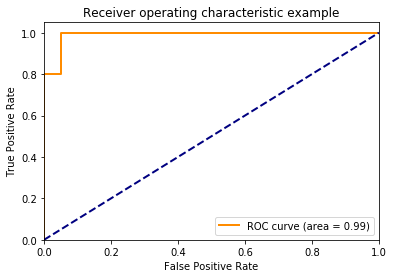

In [131]:
roc_data = fnp_conf_roc.loc[[0,4,5]].T
fpr = roc_data[4]
tpr = roc_data[5]
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [150]:
df1 = fnp_conf_roc.T
df2 = df1.loc[df1[1] == 0]
minimum = df2[2].min()
df3 = df2.loc[df2[2] == minimum]
good_thrsh_min = df3[0].min()
good_thrsh_max = df3[0].max()
print(f'Good thresholds are in the interval:')
print(f'  [{good_thrsh_min}, {good_thrsh_max}]')

Good thresholds are in the interval:
  [0.22, 0.901]


In [ ]:
#OLD CODE

# for each threshold label_score_boundary, there is a confusion matrix with TP, FP, TN, FN
# from which TPR = TP/P and FPR = FP/N can be calculated
test_w_reckonings = test_set[['abnormality','abnormality_pred']].copy()
#for thrsh in range(0,1,0.1):
thrsh=0.5
TP = 0; FP = 0; TN = 0; FN = 0
reckonings = []
fpr = np.empty(len(test_set)); tpr = np.empty(len(test_set))
for i in range(len(test_set)):
    label = test_set['abnormality'].loc[i]
    pred  = test_set['abnormality_pred'].loc[i]
    reckoning = 0 if pred < thrsh else 1
    if reckoning == label:
        if reckoning == 1:
            TP += 1
        else:
            TN += 1
    if reckoning != label:
        if reckoning == 1:
            FP += 1
        else:
            FN += 1
    reckonings.append(reckoning)
test_w_reckonings[str(thrsh)] = reckonings
confusion_matrix = np.array([[TP, FP], [FN, TN]])

In [57]:
print(confusion_matrix)
print('')
print(f'False negatives: {FN} --- want NO  false negatives (want to catch all positives/abnormalities: high sensitivity)')
print(f'False positives: {FP} --- want few false positives (want few flagged negatives/normals: high specificity)')
print('')
P = TP+FN
N = TN+FP
TPR = TP/P
FPR = FP/N
print(f'TP Rate = TPR = TP/P = TP/(TP+FN) = {TP}/({TP}+{FN}) = {TP}/{P} = {TPR}')
print(f'FP Rate = FPR = FP/N = FP/(TN+FP) = {FP}/({TN}+{FP}) = {FP}/{N} = {FPR}')
#test_w_reckonings = test_w_reckonings.drop(columns=['0.5'])
test_w_reckonings

[[20  1]
 [ 0 19]]

False negatives: 0 --- want NO  false negatives (want to catch all positives/abnormalities: high sensitivity)
False positives: 1 --- want few false positives (want few flagged negatives/normals: high specificity)

TP Rate = TPR = TP/P = TP/(TP+FN) = 20/(20+0) = 20/20 = 1.0
FP Rate = FPR = FP/N = FP/(TN+FP) = 1/(19+1) = 1/20 = 0.05


,abnormality,abnormality_pred
0,0,1.164952e-04
1,0,4.197314e-03
2,1,9.987450e-01
3,0,5.445342e-02
4,1,9.999999e-01
5,0,1.538272e-02
6,1,9.998049e-01
7,1,9.999888e-01
8,0,2.296348e-02
9,1,9.999990e-01


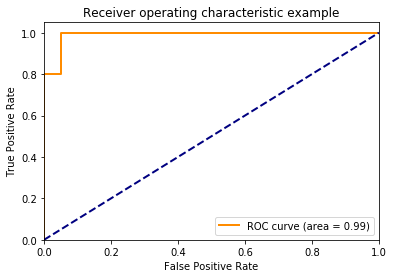

[2.0000000e+00 1.0000000e+00 9.9874496e-01 9.9794108e-01 9.0129197e-01
 2.1757499e-07]


In [19]:
fpr, tpr, thrsh = metrics.roc_curve(test_set['abnormality'], test_set['abnormality_pred'])
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print(thrsh)

In [104]:
import inspect
source_file = inspect.getsourcefile(metrics.roc_curve)
print(source_file)

/Users/zero/Tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py
